In [8]:
from collections import defaultdict, namedtuple, Counter
import numpy as np
from os import listdir
from itertools import combinations, product
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import json
import statsmodels.api as sm
import random

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [35]:
#phase_dir = '../../PhasingFamilies/phased_spark_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/spark_quads_identicals.txt'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#build = '38'
#orig_ped_file = '../../DATA/spark/spark.ped'
#data_dir = '../../DATA/spark/genotypes'

#phase_dir = '../../PhasingFamilies/phased_ihart.ms2_quads_del'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
#build = '38'
#orig_ped_file = '../../DATA/ihart.ms2/ihart.ped'
#data_dir = '../../DATA/ihart.ms2/genotypes'

phase_dir = '../../PhasingFamilies/phased_mssng_quads'
identicals_file = '../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt'
ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
build = '38'
orig_ped_file = '../../DATA/mssng/mssng.ped'
data_dir = '../../DATA/mssng/genotypes'

#phase_dir = '../../PhasingFamilies/phased_ssc.hg38'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ssc.hg38_identicals.txt'
#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#build = '38'
#orig_ped_file = '../../DATA/ssc.hg38/ssc.ped'

#phase_dir = '../../PhasingFamilies/phased_ancestry_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ancestry_quads_identicals.txt'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#build = '37'
#orig_ped_file = '../../DATA/ancestry/ancestry.ped'


In [51]:
chrom = '10'
if build == '37':
    #ctbp2_start_interval, ctbp2_end_interval = 127188569, 127688569
    ctbp2_start_interval, ctbp2_end_interval = 127188569, 128188569
    #zeb1_start_interval, zeb1_end_interval = 31607424, 31818742
elif build == '38':
    #ctbp2_start_interval, ctbp2_end_interval = 125500000, 126000000
    #ctbp2_start_interval, ctbp2_end_interval = 125500000, 126500000
    #ctbp2_start_interval, ctbp2_end_interval = 125050581, 126917556
    ctbp2_start_interval, ctbp2_end_interval = 125800000, 126000367
    #zeb1_start_interval, zeb1_end_interval = 31318417, 31529814

In [52]:
#chrom = '13'
#if build == '38':
#    ctbp2_start_interval, ctbp2_end_interval = 0, 1000000

In [53]:
def sample_to_multiplex(orig_ped_file):
    family_to_num_affected = defaultdict(int)
    family_to_num_unaffected = defaultdict(int)
    family_to_inds = defaultdict(list)
    with open(orig_ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            family_to_inds[(pieces[0], pieces[2], pieces[3])].append(pieces[1])
            if pieces[5]=='2':
                family_to_num_affected[(pieces[0], pieces[2], pieces[3])] += 1
            if pieces[5]=='1':
                family_to_num_unaffected[(pieces[0], pieces[2], pieces[3])] += 1
                
    sample_to_family_type = dict()
    for family, inds in family_to_inds.items():
        is_multiplex = family_to_num_affected[family] > 1
        is_unmultiplex = family_to_num_unaffected[family] > 1
        for ind in inds:
            sample_to_family_type[ind] = ('multiplex' if is_multiplex else 'simplex',
                                          'unmultiplex' if is_unmultiplex else 'unsimplex')
    return sample_to_family_type
sample_to_family_type = sample_to_multiplex(orig_ped_file)

In [54]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)


In [55]:
Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 'num_affected', 'num_males', 'is_multiplex', 'is_unmultiplex'])
def pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex):

    # pull identicals
    leave_out = set()
    with open(identicals_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            leave_out.update(pieces[1:])

    # pull individuals
    family_to_inds = defaultdict(list)
    sibpairs = list()
    for filename in listdir(phase_dir):
        if filename.endswith('.phased.txt'):
            family_key = filename[:-11]
            try:
                with open('%s/%s' % (phase_dir, filename), 'r')  as f:
                    header = next(f).strip().split('\t')
                    # check that we have a typical nuclear family structure
                    if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
                        individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
                        family_to_inds[family_key] = individuals
                        for child1, child2 in combinations(individuals[2:], 2):
                            if child1 not in leave_out and child2 not in leave_out and child1 in sample_to_affected and child2 in sample_to_affected:
                                sibpairs.append(Sibpair(family_key, child1, child2, individuals[0], individuals[1], 
                                    phase_dir,
                                    int(sample_to_affected[child1]=='2')+int(sample_to_affected[child2]=='2'),
                                    int(sample_to_sex[child1]=='1')+int(sample_to_sex[child2]=='1'),
                                    'multiplex' in sample_to_family_type[child1],
                                    'unmultiplex' in sample_to_family_type[child1]))
            except StopIteration:
                pass

    sibpairs = sorted(sibpairs)

    assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
    return family_to_inds, sibpairs

family_to_inds, sibpairs = pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex)


In [56]:
print('Overall')
print('families', len(family_to_inds))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))
print('is_multiplex', Counter([x.is_multiplex for x in sibpairs]))
print('is_unmultiplex', Counter([x.is_unmultiplex for x in sibpairs]))

Overall
families 770
sibpairs 727
num_affected Counter({2: 475, 1: 196, 0: 56})
is_multiplex Counter({True: 532, False: 195})
is_unmultiplex Counter({False: 654, True: 73})


In [57]:

def pull_sibpair_matches(sibpairs, family_to_inds, start_interval, end_interval):
    
    length_interval = end_interval-start_interval
    sibpair_to_index = dict([((x.family, x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)])

    # pull phase data
    # sibpair, interval, nomatch/match
    is_mat_match = -np.ones((len(sibpair_to_index),), dtype=int)
    is_pat_match = -np.ones((len(sibpair_to_index),), dtype=int)

    for sibpair_index, sibpair in enumerate(sibpairs):
        mat_match_data = np.zeros((2,), dtype=int)
        pat_match_data = np.zeros((2,), dtype=int)
        with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                if pieces[0][3:] == chrom:
                    start_pos, end_pos = [int(x) for x in pieces[-2:]]
                    state = np.array([int(x) for x in pieces[1:-2]])

                    inds = family_to_inds[sibpair.family]
                    sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
                    sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
                    sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index

                    overlap = min(end_interval, end_pos) - max(start_interval, start_pos)
                    if overlap > 0:
                        if (state[sib1_mat_index] != -1) and (state[sib2_mat_index] != -1):
                            mat_match_data[int(state[sib1_mat_index]==state[sib2_mat_index])] += overlap

                        if (state[sib1_pat_index] != -1) and (state[sib2_pat_index] != -1):
                            pat_match_data[int(state[sib1_pat_index]==state[sib2_pat_index])] += overlap

        assert np.sum(mat_match_data) <= length_interval
        assert np.sum(pat_match_data) <= length_interval

        if mat_match_data[0]>=0.9*length_interval:
            is_mat_match[sibpair_index] = 0
        if mat_match_data[1]>=0.9*length_interval:
            is_mat_match[sibpair_index] = 1
        if pat_match_data[0]>=0.9*length_interval:
            is_pat_match[sibpair_index] = 0
        if pat_match_data[1]>=0.9*length_interval:
            is_pat_match[sibpair_index] = 1

    return is_mat_match, is_pat_match

ctbp2_is_mat_match, ctbp2_is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, ctbp2_start_interval, ctbp2_end_interval)
#zeb1_is_mat_match, zeb1_is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, zeb1_start_interval, zeb1_end_interval)



In [58]:
is_aff_aff = np.array([sp.num_affected==2 for sp in sibpairs])
is_aff_typ = np.array([sp.num_affected==1 for sp in sibpairs])
is_typ_typ = np.array([sp.num_affected==0 for sp in sibpairs])

is_m_m = np.array([sp.num_males==2 for sp in sibpairs])
is_m_f = np.array([sp.num_males==1 for sp in sibpairs])
is_f_f = np.array([sp.num_males==0 for sp in sibpairs])

is_multiplex = np.array([sp.is_multiplex for sp in sibpairs])
is_unmultiplex = np.array([sp.is_unmultiplex for sp in sibpairs])

print(np.sum(is_m_m & is_typ_typ), np.sum(is_m_f & is_typ_typ), np.sum(is_f_f & is_typ_typ))

print('All', np.sum(is_typ_typ))
print(np.sum(ctbp2_is_mat_match[is_typ_typ]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ]==1))
print(np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))

print('multiplex')
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_multiplex]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_multiplex]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ & is_multiplex]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))

print('simplex')
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & ~is_multiplex]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ & ~is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & ~is_multiplex]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & ~is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ & ~is_multiplex]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))

print('MM', np.sum(is_typ_typ & is_m_m))
print('MM', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_m]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_m]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_m]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_m]!=-1),
                             p=0.5, alternative='greater'))
print('MM', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_m]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_m]!=-1),
                             p=0.5, alternative='greater'))
print('MM', stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_m]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_m]!=-1),
                             p=0.5, alternative='greater'))

print('MF', np.sum(is_typ_typ & is_m_f))
print('MF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_f]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_f]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_f]!=-1),
                             p=0.5, alternative='greater'))
print('MF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_m_f]!=-1),
                             p=0.5, alternative='greater'))
print('MF', stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_f]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ & is_m_f]!=-1),
                             p=0.5, alternative='greater'))

print('FF', np.sum(is_typ_typ & is_f_f))
print('FF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_f_f]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_f_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_f_f]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ & is_f_f]!=-1),
                             p=0.5, alternative='greater'))
print('FF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ & is_f_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ & is_f_f]!=-1),
                             p=0.5, alternative='greater'))
print('FF', stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ & is_f_f]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ & is_f_f]!=-1),
                             p=0.5, alternative='greater'))

17 20 19
All 56
54
94
0.08983250740401501
0.032454323536136094
0.559802089359664
multiplex
0.11328125000000001
0.0625
0.6875
simplex
0.18999969820595916
0.11102641007801138
0.5626853438097896
MM 17
MM 0.22912915982306015
MM 0.16615295410156253
MM 0.6127929687499998
MF 20
MF 0.4300250329542902
MF 0.49999999999999983
MF 0.4999999999999999
FF 19
FF 0.14810318429954358
FF 0.04812622070312499
FF 0.696380615234375


In [59]:
is_aff_aff = np.array([sp.num_affected==2 for sp in sibpairs])
is_aff_typ = np.array([sp.num_affected==1 for sp in sibpairs])
is_typ_typ = np.array([sp.num_affected==0 for sp in sibpairs])

is_m_m = np.array([sp.num_males==2 for sp in sibpairs])
is_m_f = np.array([sp.num_males==1 for sp in sibpairs])
is_f_f = np.array([sp.num_males==0 for sp in sibpairs])

is_multiplex = np.array([sp.is_multiplex for sp in sibpairs])
is_unmultiplex = np.array([sp.is_unmultiplex for sp in sibpairs])

print(np.sum(is_m_m & is_aff_aff), np.sum(is_m_f & is_aff_aff), np.sum(is_f_f & is_aff_aff))

print('All', np.sum(is_aff_aff))
print(np.sum(ctbp2_is_mat_match[is_aff_aff]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff]==1))
print(np.sum(ctbp2_is_mat_match[is_aff_aff]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff]!=-1))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff]!=-1),
                             p=0.5, alternative='greater'))

print('multiplex')
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_multiplex]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_multiplex]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff & is_multiplex]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff & is_multiplex]!=-1),
                             p=0.5, alternative='greater'))

print('simplex')
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & ~is_multiplex]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff & ~is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & ~is_multiplex]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & ~is_multiplex]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff & ~is_multiplex]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff & ~is_multiplex]!=-1),
                             p=0.5, alternative='greater'))

print('MM', np.sum(is_aff_aff & is_m_m))
print('MM', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_m]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_m]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_m]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_m]!=-1),
                             p=0.5, alternative='greater'))
print('MM', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_m]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_m]!=-1),
                             p=0.5, alternative='greater'))
print('MM', stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_m]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_m]!=-1),
                             p=0.5, alternative='greater'))

print('MF', np.sum(is_aff_aff & is_m_f))
print('MF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_f]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_f]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_f]!=-1),
                             p=0.5, alternative='greater'))
print('MF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_m_f]!=-1),
                             p=0.5, alternative='greater'))
print('MF', stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_f]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff & is_m_f]!=-1),
                             p=0.5, alternative='greater'))

print('FF', np.sum(is_aff_aff & is_f_f))
print('FF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_f_f]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_f_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_f_f]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff & is_f_f]!=-1),
                             p=0.5, alternative='greater'))
print('FF', stats.binom_test(np.sum(ctbp2_is_mat_match[is_aff_aff & is_f_f]==1), 
                             np.sum(ctbp2_is_mat_match[is_aff_aff & is_f_f]!=-1),
                             p=0.5, alternative='greater'))
print('FF', stats.binom_test(np.sum(ctbp2_is_pat_match[is_aff_aff & is_f_f]==1), 
                              np.sum(ctbp2_is_pat_match[is_aff_aff & is_f_f]!=-1),
                             p=0.5, alternative='greater'))

266 179 30
All 475
433
808
0.02243459723346344
0.05864859387693734
0.11012782128861183
multiplex
0.02243459723346344
0.05864859387693734
0.11012782128861183
simplex
1.0
1.0
1.0
MM 266
MM 0.0015333726729683734
MM 0.016333325267066583
MM 0.02359562295902576
MF 179
MF 0.7158730486616511
MF 0.5
MF 0.804784916018647
FF 30
FF 0.38543349728651377
FF 0.7293719053268433
FF 0.20243644714355474


In [60]:
c = np.array([[np.sum((ctbp2_is_pat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]])
print(c)
print(stats.fisher_exact(c))

c = np.array([[np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]])
print(c)
print(stats.fisher_exact(c))

c = [[np.sum((ctbp2_is_pat_match==1) & is_aff_aff), np.sum((ctbp2_is_pat_match==0) & is_aff_aff)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]]
print(c)
print(stats.fisher_exact(c))

[[22 22]
 [76 86]]
(1.131578947368421, 0.7364021381194903)
[[14 22]
 [76 86]]
(0.7200956937799043, 0.46036926571274844)
[[221, 195], [76, 86]]
(1.2824561403508772, 0.19503030834415233)


In [61]:
def exact_confidence_interval(count, n, p=0.25):
    p_hat = count/n
    alpha = 0.05
    ps = np.arange(0, 1, 0.0001)

    conf = np.zeros((2, len(count)))
    for i in range(len(count)):
        conf[0, i] = p_hat[i] - ps[np.searchsorted(-stats.binom.cdf(count[i]-1, n[i], ps), -(1 - alpha/2))]
        conf[1, i] = ps[np.searchsorted(-stats.binom.cdf(count[i], n[i], ps), -alpha/2)] - p_hat[i]
        print(i, p_hat[i], conf[:, i], stats.binom_test(count[i], n[i], p=p))
    return p_hat, conf

#print(exact_confidence_interval(both_counts, n))


0 0.3684210526315789 [0.15022105 0.17167895] 0.09449248536714791
1 0.3488372093023256 [0.08173721 0.08896279] 0.014193430732473866
2 0.39820359281437123 [0.05280359 0.05479641] 2.8601211255904665e-09
0 0.10526315789473684 [0.07576316 0.14283684] 0.0390715989994117
1 0.11627906976744186 [0.04967907 0.06832093] 0.0002223856226648219
2 0.12275449101796407 [0.03315449 0.04014551] 9.722575650865914e-09
0 0.2631578947368421 [0.12905789 0.16794211] 0.8519340037371725
1 0.18604651162790697 [0.06304651 0.07805349] 0.1035722041876087
2 0.12574850299401197 [0.0335485 0.0404515] 2.8630076948512133e-08
0 0.2631578947368421 [0.12905789 0.16794211] 0.8519340037371725
1 0.3488372093023256 [0.08173721 0.08896279] 0.014193430732473866
2 0.3532934131736527 [0.05119341 0.05390659] 2.7716525097086133e-05


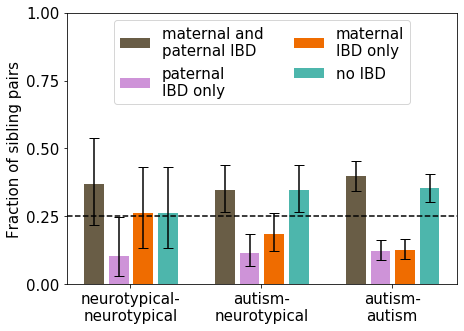

In [62]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

def plot_with_error(counts, n, x, color, label, p=0.25):
    p_hat, conf = exact_confidence_interval(counts[n!=0], n[n!=0], p=0.25)
    plt.bar(x[n!=0], p_hat, width, 
                 color=color, label=label)
    plt.errorbar(x[n!=0], p_hat, yerr=conf, 
                 color='black', linestyle='', capsize=5)
    

n = np.array([np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_typ_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_aff)])

both_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_aff)])

pat_only_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_aff)])

mat_only_counts = np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_aff)])
    
neither_counts = np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.15

plot_with_error(both_counts, n, np.arange(3), colors[0], 'maternal and\npaternal IBD')
plot_with_error(pat_only_counts, n, np.arange(3)+1.25*width, colors[1], 'paternal\nIBD only')
plot_with_error(mat_only_counts, n, np.arange(3)+2.50*width, colors[2], 'maternal\nIBD only')
plot_with_error(neither_counts, n, np.arange(3)+3.75*width, colors[3], 'no IBD')

plt.axhline(0.25, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(3)+1.85*width, ['neurotypical-\nneurotypical', 'autism-\nneurotypical', 'autism-\nautism'])
plt.legend(loc='upper center', ncol=2)
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')
plt.show()

0 0.3684210526315789 [0.15022105 0.17167895] 0.09449248536714791
1 0.3488372093023256 [0.08173721 0.08896279] 0.014193430732473866
2 0.39820359281437123 [0.05280359 0.05479641] 2.8601211255904665e-09
0 0.3684210526315789 [0.15022105 0.17167895] 0.09449248536714791
1 0.3023255813953488 [0.07762558 0.08707442] 0.18576854278069466
2 0.24850299401197604 [0.04540299 0.04999701] 1.0
0 0.2631578947368421 [0.12905789 0.16794211] 0.8519340037371725
1 0.3488372093023256 [0.08173721 0.08896279] 0.014193430732473866
2 0.3532934131736527 [0.05119341 0.05390659] 2.7716525097086133e-05


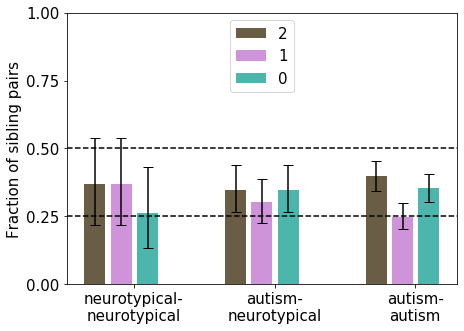

In [63]:
n = np.array([np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_typ_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_aff)])

counts2 = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_aff)])

counts1 = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_aff)])

counts1 += np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_aff)])
    
counts0 = np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.15

plot_with_error(counts2, n, np.arange(3), colors[0], '2')
plot_with_error(counts1, n, np.arange(3)+1.25*width, colors[1], '1')
plot_with_error(counts0, n, np.arange(3)+2.5*width, colors[3], '0')

plt.axhline(0.25, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(3)+1.85*width, ['neurotypical-\nneurotypical', 'autism-\nneurotypical', 'autism-\nautism'])
plt.legend(loc='upper center')
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')
plt.show()

In [64]:
print(n)

[ 38 129 334]


In [65]:
print(list(product(*[[0, 1], [2, 3]])))

[(0, 2), (0, 3), (1, 2), (1, 3)]


0.7881705639614855


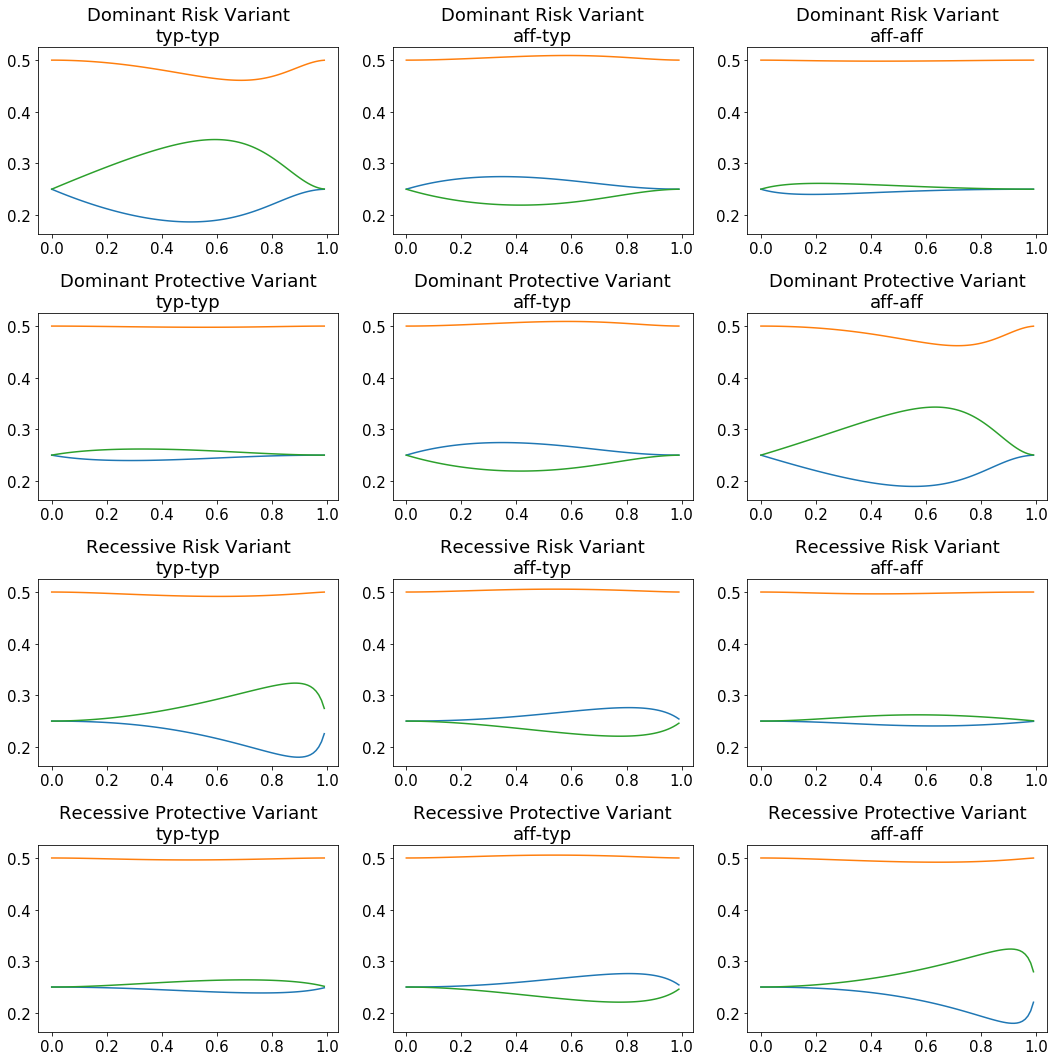

In [66]:
plt.figure(figsize=(15, 15))

p_aut = (2*np.sum(is_aff_aff) + np.sum(is_aff_typ))/(2*np.sum(is_aff_aff + is_aff_typ + is_typ_typ))
print(p_aut)
p = np.arange(0, 1, 0.01)

def get_p_share(p, a, b, c):
    # typ-typ/aut-typ/aut-aut, share0/share1/share2, afs
    p_share = np.zeros((3, 3, len(p)))
    prob_of_autism = [a, b, c]
    
    for anc_vars in product([0, 1], repeat=4):
        prob_of_vars = np.prod([p if x==1 else (1-p) for x in anc_vars], axis=0)
        for inherit in product(*[[0, 1], [2, 3], [0, 1], [2, 3], [0, 1], [2, 3]]):
            # typ-typ
            prob_of_event = prob_of_vars/64
            #prob_of_event *= (1-prob_of_autism[anc_vars[0]+anc_vars[1]]) # mom no autism
            #prob_of_event *= (1-prob_of_autism[anc_vars[2]+anc_vars[3]]) # dad no autism
            prob_of_event *= (1-prob_of_autism[anc_vars[inherit[0]]+anc_vars[inherit[1]]]) # child1 no autism
            prob_of_event *= (1-prob_of_autism[anc_vars[inherit[2]]+anc_vars[inherit[3]]]) # child2 no autism
            prob_of_event *= prob_of_autism[anc_vars[inherit[4]]+anc_vars[inherit[5]]] # child3 autism
            p_share[0, int(inherit[0]==inherit[2]) + int(inherit[1]==inherit[3]), :] += prob_of_event
            
            # aut-typ
            prob_of_event = prob_of_vars/64
            #prob_of_event *= (1-prob_of_autism[anc_vars[0]+anc_vars[1]]) # mom no autism
            #prob_of_event *= (1-prob_of_autism[anc_vars[2]+anc_vars[3]]) # dad no autism
            prob_of_event *= prob_of_autism[anc_vars[inherit[0]]+anc_vars[inherit[1]]] # child1 autism
            prob_of_event *= (1-prob_of_autism[anc_vars[inherit[2]]+anc_vars[inherit[3]]]) # child2 no autism
            p_share[1, int(inherit[0]==inherit[2]) + int(inherit[1]==inherit[3]), :] += prob_of_event
            prob_of_event = prob_of_vars/64
            #prob_of_event *= (1-prob_of_autism[anc_vars[0]+anc_vars[1]]) # mom no autism
            #prob_of_event *= (1-prob_of_autism[anc_vars[2]+anc_vars[3]]) # dad no autism
            prob_of_event *= (1-prob_of_autism[anc_vars[inherit[0]]+anc_vars[inherit[1]]]) # child1 no autism
            prob_of_event *= prob_of_autism[anc_vars[inherit[2]]+anc_vars[inherit[3]]] # child2 autism
            p_share[1, int(inherit[0]==inherit[2]) + int(inherit[1]==inherit[3]), :] += prob_of_event
            # aut-aut
            prob_of_event = prob_of_vars/64
            #prob_of_event *= (1-prob_of_autism[anc_vars[0]+anc_vars[1]]) # mom no autism
            #prob_of_event *= (1-prob_of_autism[anc_vars[2]+anc_vars[3]]) # dad no autism
            prob_of_event *= prob_of_autism[anc_vars[inherit[0]]+anc_vars[inherit[1]]] # child1 autism
            prob_of_event *= prob_of_autism[anc_vars[inherit[2]]+anc_vars[inherit[3]]] # child2 autism
            p_share[2, int(inherit[0]==inherit[2]) + int(inherit[1]==inherit[3]), :] += prob_of_event

    #print(np.sum(p_share, axis=(0, 1)))
    #assert np.all(np.isclose(np.sum(p_share, axis=(0, 1)), 1))
    p_share[0, :, :] = p_share[0, :, :]/np.sum(p_share[0, :, :], axis=0)
    p_share[1, :, :] = p_share[1, :, :]/np.sum(p_share[1, :, :], axis=0)
    p_share[2, :, :] = p_share[2, :, :]/np.sum(p_share[2, :, :], axis=0)
    
    #print(np.sum(p_share, axis=1))
    assert np.all(np.isclose(np.sum(p_share, axis=1), 1))
    return p_share

ax = plt.subplot(4, 3, 1)

labels = ['typ-typ', 'aff-typ', 'aff-aff']

p_share = get_p_share(p, 0.5, 0.9, 0.9)
for status in range(3):
    plt.subplot(4, 3, status+1, sharey=ax)
    x = plt.plot(p, p_share[status, 0, :])
    #plt.axhline(counts0[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 1, :])
    #plt.axhline(counts1[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 2, :])
    #plt.axhline(counts2[status]/n[status], linestyle='--', color = x[0].get_color())

    #plt.axhline(0.25, color='black', linestyle='--')
    #plt.axhline(0.5, color='black', linestyle='--')
    plt.title('Dominant Risk Variant\n%s' % labels[status])
    
p_share = get_p_share(p, 0.5, 0.1, 0.1)
for status in range(3):
    plt.subplot(4, 3, status+4, sharey=ax)
    x = plt.plot(p, p_share[status, 0, :])
   # plt.axhline(counts0[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 1, :])
    #plt.axhline(counts1[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 2, :])
    #plt.axhline(counts2[status]/n[status], linestyle='--', color = x[0].get_color())

    #plt.axhline(0.25, color='black', linestyle='--')
    #plt.axhline(0.5, color='black', linestyle='--')
    plt.title('Dominant Protective Variant\n%s' % labels[status])
    
p_share = get_p_share(p, 0.5, 0.5, 0.9)
for status in range(3):
    plt.subplot(4, 3, status+7, sharey=ax)
    x = plt.plot(p, p_share[status, 0, :])
    #plt.axhline(counts0[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 1, :])
    #plt.axhline(counts1[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 2, :])
    #plt.axhline(counts2[status]/n[status], linestyle='--', color = x[0].get_color())

    #plt.axhline(0.25, color='black', linestyle='--')
    #plt.axhline(0.5, color='black', linestyle='--')
    plt.title('Recessive Risk Variant\n%s' % labels[status])
    
p_share = get_p_share(p, 0.5, 0.5, 0.1)
for status in range(3):
    plt.subplot(4, 3, status+10, sharey=ax)
    x = plt.plot(p, p_share[status, 0, :])
    #plt.axhline(counts0[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 1, :])
    #plt.axhline(counts1[status]/n[status], linestyle='--', color = x[0].get_color())
    x = plt.plot(p, p_share[status, 2, :])
    #plt.axhline(counts2[status]/n[status], linestyle='--', color = x[0].get_color())

    #plt.axhline(0.25, color='black', linestyle='--')
    #plt.axhline(0.5, color='black', linestyle='--')
    plt.title('Recessive Protective Variant\n%s' % labels[status])

plt.tight_layout()
plt.show()

In [67]:
actual_value = np.zeros((3, 3))
actual_value[0, 0] = counts0[0]
actual_value[0, 1] = counts1[0]
actual_value[0, 2] = counts2[0]
actual_value[1, 0] = counts0[1]
actual_value[1, 1] = counts1[1]
actual_value[1, 2] = counts2[1]
actual_value[2, 0] = counts0[2]
actual_value[2, 1] = counts1[2]
actual_value[2, 2] = counts2[2]

In [68]:
print(actual_value[0, np.newaxis, :].dot(np.log10(p_share[0, :, :])))

[[-18.66385973 -18.66376101 -18.66347028 -18.6629958  -18.66234596
  -18.66152929 -18.66055436 -18.65942982 -18.65816436 -18.65676666
  -18.65524538 -18.65360913 -18.65186649 -18.65002592 -18.64809579
  -18.64608433 -18.64399966 -18.64184971 -18.63964227 -18.63738493
  -18.63508508 -18.63274992 -18.63038643 -18.62800137 -18.62560127
  -18.62319242 -18.62078089 -18.61837251 -18.61597284 -18.61358725
  -18.61122081 -18.6088784  -18.60656462 -18.60428388 -18.60204032
  -18.59983786 -18.59768022 -18.59557087 -18.59351309 -18.59150994
  -18.5895643  -18.58767884 -18.58585605 -18.58409826 -18.58240759
  -18.58078605 -18.57923546 -18.57775752 -18.57635377 -18.57502565
  -18.57377446 -18.57260142 -18.57150762 -18.57049408 -18.56956174
  -18.56871148 -18.56794411 -18.56726039 -18.56666105 -18.56614681
  -18.56571837 -18.56537642 -18.56512169 -18.56495491 -18.5648769
  -18.5648885  -18.56499066 -18.56518443 -18.56547098 -18.56585164
  -18.56632791 -18.5669015  -18.56757437 -18.56834877 -18.56922

In [69]:
def calculate_loss(p_share, actual_counts):
    loss = np.zeros((len(p),))
    loss -= actual_counts[0, np.newaxis, :].dot(np.log10(p_share[0, :, :])).flatten()
    loss -= actual_counts[1, np.newaxis, :].dot(np.log10(p_share[1, :, :])).flatten()
    loss -= actual_counts[2, np.newaxis, :].dot(np.log10(p_share[2, :, :])).flatten()
    return loss

best_as, best_bs, best_cs, best_ps = [], [], [], []
best_loss = 10000000

for a in np.arange(0.05, 1.0, 0.1):
    for b in np.arange(0.05, 1.0, 0.1):
        for c in np.arange(0.05, 1.0, 0.1):
            p_share = get_p_share(p, a, b, c)
            loss = calculate_loss(p_share, actual_value)
            if np.isclose(best_loss, np.min(loss)):
                best_as.append(a)
                best_bs.append(b)
                best_cs.append(c)
                best_ps.append(p[np.argmin(loss)])
            elif np.min(loss)<best_loss:
                print(np.min(loss), best_loss)
                best_loss = np.min(loss)
                best_as, best_bs, best_cs = [a], [b], [c]
                best_ps = [p[np.argmin(loss)]]
                
print(best_as, best_bs, best_cs, best_ps, best_loss)

260.6919762450068 10000000
258.58286568870153 260.6919762450068
256.978364521621 258.58286568870153
256.07897828674584 256.978364521621
255.5141252905576 256.07897828674584
255.1356302459208 255.5141252905576
254.86794662354163 255.1356302459208
254.6751180933698 254.86794662354163
254.5014502058305 254.6751180933698
254.40832522709803 254.5014502058305
254.38239912388866 254.40832522709803
254.31880410900897 254.38239912388866
254.26314021086577 254.31880410900897
[0.15000000000000002, 0.9500000000000002] [0.05, 0.05] [0.9500000000000002, 0.15000000000000002] [0.14, 0.86] 254.26314021086577


//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


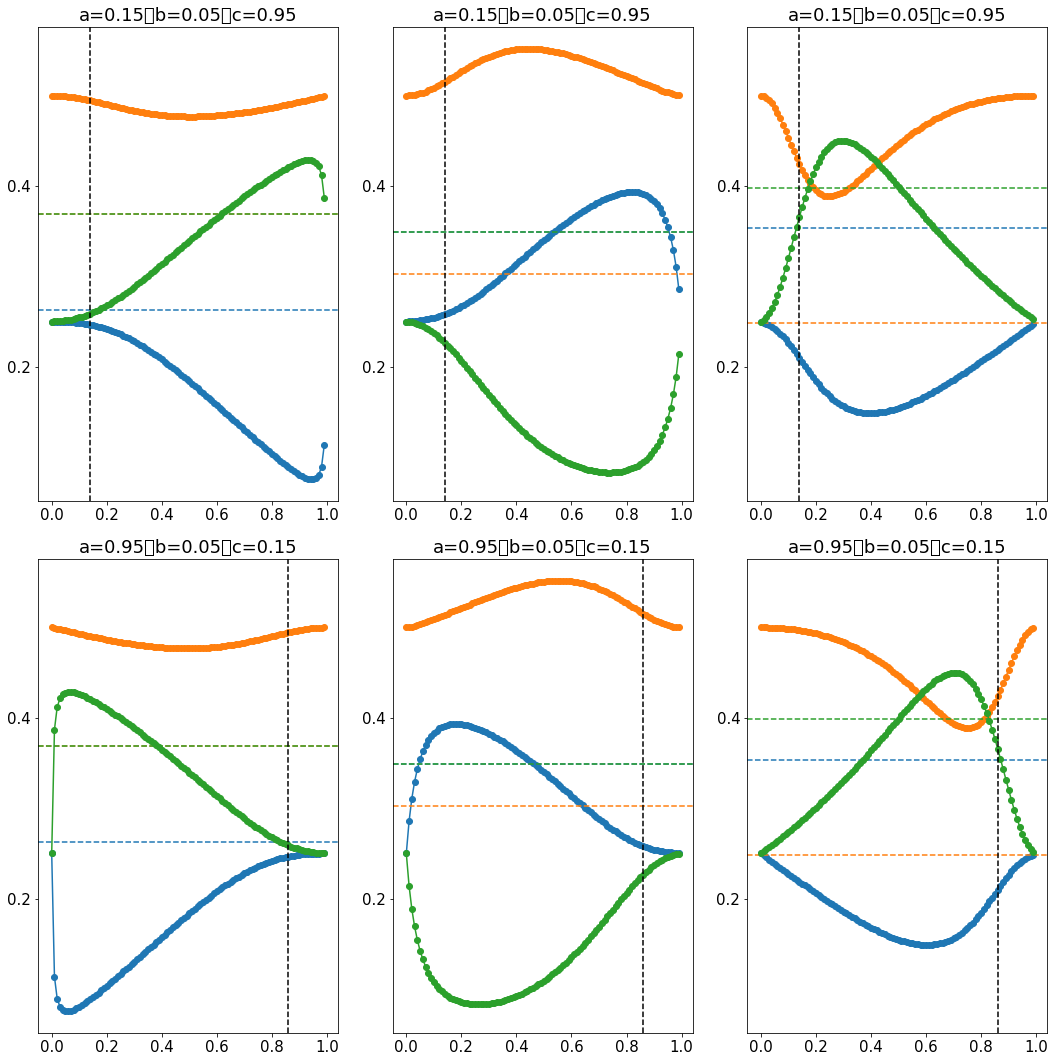

In [70]:
plt.figure(figsize=(15, 15))

for i, (best_a, best_b, best_c, best_p) in enumerate(zip(best_as, best_bs, best_cs, best_ps)):
    p_share = get_p_share(p, best_a, best_b, best_c)
    #print(p_share)
    for status in range(3):
        plt.subplot(len(best_as), 3, status+1+(3*i), sharey=ax)
        plt.title('a=%0.2f\tb=%0.2f\tc=%0.2f' % (best_a, best_b, best_c))
        x = plt.plot(p, p_share[status, 0, :], marker='o')
        plt.axhline(counts0[status]/n[status], linestyle='--', color = x[0].get_color())
        x = plt.plot(p, p_share[status, 1, :], marker='o')
        plt.axhline(counts1[status]/n[status], linestyle='--', color = x[0].get_color())
        x = plt.plot(p, p_share[status, 2, :], marker='o')
        plt.axhline(counts2[status]/n[status], linestyle='--', color = x[0].get_color())

        plt.axvline(best_p, color='black', linestyle='--')
        
    

plt.tight_layout()
plt.show()

0 0.3684210526315789 [0.15022105 0.17167895] 0.09449248536714791
1 0.10526315789473684 [0.07576316 0.14283684] 0.0390715989994117
2 0.2631578947368421 [0.12905789 0.16794211] 0.8519340037371725
3 0.2631578947368421 [0.12905789 0.16794211] 0.8519340037371725
0 0.39820359281437123 [0.05280359 0.05479641] 2.8601211255904665e-09
1 0.12275449101796407 [0.03315449 0.04014551] 9.722575650865914e-09
2 0.12574850299401197 [0.0335485 0.0404515] 2.8630076948512133e-08
3 0.3532934131736527 [0.05119341 0.05390659] 2.7716525097086133e-05


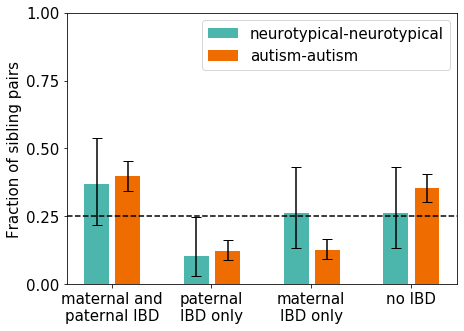

In [71]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']
 

n_typ = np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_typ_typ)
n_aff = np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_aff)

typ_typ_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_typ_typ)])

aff_aff_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.25

plot_with_error(typ_typ_counts, n_typ*np.ones((4,)), np.arange(4), colors[3], 'neurotypical-neurotypical')
plot_with_error(aff_aff_counts, n_aff*np.ones((4,)), np.arange(4)+1.25*width, colors[2], 'autism-autism')

plt.axhline(0.25, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(4)+0.6*width, ['maternal and\npaternal IBD', 'paternal\nIBD only', 'maternal\nIBD only', 'no IBD'])
plt.legend()
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')
plt.show()

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']
 
plt.figure(figsize=(15, 5))
width = 0.25

plt.subplot(1, 3, 1)
a, b = np.sum((ctbp2_is_mat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==1) & is_typ_typ)
c, d = np.sum((ctbp2_is_mat_match==1) & (is_aff_typ | is_aff_aff)), np.sum((ctbp2_is_pat_match==1) & (is_aff_typ | is_aff_aff))
plot_with_error(np.array([a, b, a+b]), np.array([a+c, b+d, a+b+c+d]), np.arange(3), colors[2], 'IBD')

e, f = np.sum((ctbp2_is_mat_match==0) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)
g, h = np.sum((ctbp2_is_mat_match==0) & (is_aff_typ | is_aff_aff)), np.sum((ctbp2_is_pat_match==0) & (is_aff_typ | is_aff_aff))
plot_with_error(np.array([e, f, e+f]), np.array([e+g, f+h, e+f+g+h]), np.arange(3)+1.25*width, colors[3], 'no IBD')

print('typ_typ mat', stats.chi2_contingency([[a, e], [c, g]])[1])
print('typ_typ pat', stats.chi2_contingency([[b, f], [d, h]])[1])
print('typ_typ all', stats.chi2_contingency([[a+b, e+f], [c+d, g+h]])[1])

baseline = np.sum(is_typ_typ)/np.sum((is_typ_typ | is_aff_typ | is_aff_aff))
plt.axhline(baseline, color='black', linestyle='--')

plt.title('typ-typ (n=%d)' % np.sum(is_typ_typ))
plt.ylim(np.clip(baseline-0.1, 0, 1), baseline+0.1, 0, 1)
plt.xticks(np.arange(3)+0.6*width, ['mat', 'pat', 'all'])
plt.ylabel('Fraction of sibling pairs')
plt.legend()

plt.subplot(1, 3, 2)
a, b = np.sum((ctbp2_is_mat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==1) & is_aff_typ)
c, d = np.sum((ctbp2_is_mat_match==1) & (is_typ_typ | is_aff_aff)), np.sum((ctbp2_is_pat_match==1) & (is_typ_typ | is_aff_aff))
plot_with_error(np.array([a, b, a+b]), np.array([a+c, b+d, a+b+c+d]), np.arange(3), colors[2], 'IBD')

e, f = np.sum((ctbp2_is_mat_match==0) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)
g, h = np.sum((ctbp2_is_mat_match==0) & (is_typ_typ | is_aff_aff)), np.sum((ctbp2_is_pat_match==0) & (is_typ_typ | is_aff_aff))
plot_with_error(np.array([e, f, e+f]), np.array([e+g, f+h, e+f+g+h]), np.arange(3)+1.25*width, colors[3], 'no IBD')

print('aff_typ mat', stats.chi2_contingency([[a, e], [c, g]])[1])
print('aff_typ pat', stats.chi2_contingency([[b, f], [d, h]])[1])
print('aff_typ all', stats.chi2_contingency([[a+b, e+f], [c+d, g+h]])[1])

baseline = np.sum(is_aff_typ)/np.sum((is_typ_typ | is_aff_typ | is_aff_aff))
plt.axhline(baseline, color='black', linestyle='--')

plt.title('aff-typ (n=%d)' % np.sum(is_aff_typ))
plt.ylim(np.clip(baseline-0.1, 0, 1), np.clip(baseline+0.1, 0, 1))
plt.xticks(np.arange(3)+0.6*width, ['mat', 'pat', 'all'])
plt.ylabel('Fraction of sibling pairs')
plt.legend()

plt.subplot(1, 3, 3)
a, b = np.sum((ctbp2_is_mat_match==1) & is_aff_aff), np.sum((ctbp2_is_pat_match==1) & is_aff_aff)
c, d = np.sum((ctbp2_is_mat_match==1) & (is_typ_typ | is_aff_typ)), np.sum((ctbp2_is_pat_match==1) & (is_typ_typ | is_aff_typ))
plot_with_error(np.array([a, b, a+b]), np.array([a+c, b+d, a+b+c+d]), np.arange(3), colors[2], 'IBD')

e, f = np.sum((ctbp2_is_mat_match==0) & is_aff_aff), np.sum((ctbp2_is_pat_match==0) & is_aff_aff)
g, h = np.sum((ctbp2_is_mat_match==0) & (is_typ_typ | is_aff_typ)), np.sum((ctbp2_is_pat_match==0) & (is_typ_typ | is_aff_typ))
plot_with_error(np.array([e, f, e+f]), np.array([e+g, f+h, e+f+g+h]), np.arange(3)+1.25*width, colors[3], 'no IBD')

print('aff_aff mat', stats.chi2_contingency([[a, e], [c, g]])[1])
print('aff_aff pat', stats.chi2_contingency([[b, f], [d, h]])[1])
print('aff_aff all', stats.chi2_contingency([[a+b, e+f], [c+d, g+h]])[1])

baseline = np.sum(is_aff_aff)/np.sum((is_typ_typ | is_aff_typ | is_aff_aff))
plt.axhline(baseline, color='black', linestyle='--')

plt.title('aff-aff (n=%d)' % np.sum(is_aff_aff))
plt.ylim(np.clip(baseline-0.1, 0, 1), np.clip(baseline+0.1, 0, 1))
plt.xticks(np.arange(3)+0.6*width, ['mat', 'pat', 'all'])
plt.ylabel('Fraction of sibling pairs')
plt.legend()

#plt.axhline(0.25, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
#plt.legend()
#plt.ylim([0, 1.4])
#plt.yticks(np.arange(0, 1.25, 0.25))

plt.tight_layout()
plt.show()

In [ ]:
print(np.sum((ctbp2_is_mat_match==1) & is_typ_typ) + np.sum((ctbp2_is_pat_match==1) & is_typ_typ))
print(np.sum((ctbp2_is_mat_match==0) & is_typ_typ) + np.sum((ctbp2_is_pat_match==0) & is_typ_typ))
print(len(is_typ_typ))

In [ ]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
a, b = np.sum((ctbp2_is_mat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==1) & is_typ_typ)
c, d = np.sum((ctbp2_is_mat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==1) & is_aff_typ)
plot_with_error(np.array([a, b, a+b]), np.array([a+c, b+d, a+b+c+d]), np.arange(3), colors[2], 'IBD')

e, f = np.sum((ctbp2_is_mat_match==0) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)
g, h = np.sum((ctbp2_is_mat_match==0) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)
plot_with_error(np.array([e, f, e+f]), np.array([e+g, f+h, e+f+g+h]), np.arange(3)+1.25*width, colors[3], 'no IBD')

baseline = np.sum(is_typ_typ)/np.sum((is_typ_typ | is_aff_typ))
plt.axhline(baseline, color='black', linestyle='--')

plt.title('IBD Sharing with NT sibling (n=%d)' % (np.sum(is_typ_typ)+np.sum(is_aff_typ)))
plt.ylim(np.clip(baseline-0.1, 0, 1), baseline+0.1, 0, 1)
plt.xticks(np.arange(3)+0.6*width, ['mat', 'pat', 'all'])
plt.ylabel('Probability child is NT')
plt.legend()

print('mat', stats.chi2_contingency([[a, e], [c, g]])[1])
print('pat', stats.chi2_contingency([[b, f], [d, h]])[1])
print('all', stats.chi2_contingency([[a+b, e+f], [c+d, g+h]])[1])

plt.subplot(1, 2, 2)
a, b = np.sum((ctbp2_is_mat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==1) & is_aff_typ)
c, d = np.sum((ctbp2_is_mat_match==1) & is_aff_aff), np.sum((ctbp2_is_pat_match==1) & is_aff_aff)
plot_with_error(np.array([a, b, a+b]), np.array([a+c, b+d, a+b+c+d]), np.arange(3), colors[2], 'IBD')

e, f = np.sum((ctbp2_is_mat_match==0) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)
g, h = np.sum((ctbp2_is_mat_match==0) & is_aff_aff), np.sum((ctbp2_is_pat_match==0) & is_aff_aff)
plot_with_error(np.array([e, f, e+f]), np.array([e+g, f+h, e+f+g+h]), np.arange(3)+1.25*width, colors[3], 'no IBD')

baseline = np.sum(is_aff_typ)/np.sum((is_aff_aff | is_aff_typ))
plt.axhline(baseline, color='black', linestyle='--')

plt.title('IBD Sharing with AUT sibling (n=%d)' % (np.sum(is_aff_aff)+np.sum(is_aff_typ)))
plt.ylim(np.clip(baseline-0.1, 0, 1), baseline+0.1, 0, 1)
plt.xticks(np.arange(3)+0.6*width, ['mat', 'pat', 'all'])
plt.ylabel('Probability child is NT')
plt.legend()

print('mat', stats.chi2_contingency([[a, e], [c, g]])[1])
print('pat', stats.chi2_contingency([[b, f], [d, h]])[1])
print('all', stats.chi2_contingency([[a+b, e+f], [c+d, g+h]])[1])


plt.show()

In [ ]:
#json_sibpairs = []
#for x, mm, pm in zip(sibpairs, ctbp2_is_mat_match, ctbp2_is_pat_match):
#    json_sibpairs.append(x._asdict())
#    json_sibpairs[-1]['mat_share'] = int(mm)
#    json_sibpairs[-1]['pat_share'] = int(pm)#
#
#with open('%s/spark_quads_sibpairs.json' % phase_dir, 'w+') as f:
#    json.dump(json_sibpairs, f, indent=4)


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']


typ_typ_counts = np.array([np.sum((ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==1) & is_typ_typ)])

aff_typ_counts = np.array([np.sum((ctbp2_is_mat_match==1) & is_aff_typ),
                           np.sum((ctbp2_is_pat_match==1) & is_aff_typ)])

aff_aff_counts = np.array([np.sum((ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==1) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.15

if np.sum(is_typ_typ)>0:
    plot_with_error(typ_typ_counts, np.array([np.sum((ctbp2_is_mat_match!=-1) & is_typ_typ),
                                     np.sum((ctbp2_is_pat_match!=-1) & is_typ_typ)]), 
                    np.arange(2), colors[3], 'neurotypical-neurotypical', p=0.5)
if np.sum(is_aff_typ)>0:
    plot_with_error(aff_typ_counts, np.array([np.sum((ctbp2_is_mat_match!=-1) & is_aff_typ),
                                     np.sum((ctbp2_is_pat_match!=-1) & is_aff_typ)]), 
                    np.arange(2)+1.25*width, colors[1], 'autism-neurotypical', p=0.5)
if np.sum(is_aff_aff)>0:
    plot_with_error(aff_aff_counts, np.array([np.sum((ctbp2_is_mat_match!=-1) & is_aff_aff),
                                 np.sum((ctbp2_is_pat_match!=-1) & is_aff_aff)]), 
                np.arange(2)+2.5*width, colors[2], 'autism-autism', p=0.5)

plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(2)+0.6*width, ['maternal IBD', 'paternal IBD'])
plt.legend()
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')

plt.show()

# Can we predict autism based on sibling IBD?

In [36]:
parents_to_children = defaultdict(set)
for x in sibpairs:
    parents_to_children[(x.mom, x.dad, x.family.split('.')[0])].add(x.sibling1)
    parents_to_children[(x.mom, x.dad, x.family.split('.')[0])].add(x.sibling2)
print(len(parents_to_children), Counter([len(x[1]) for x in parents_to_children.items()]))

451 Counter({2: 236, 3: 182, 4: 29, 7: 2, 5: 2})


In [37]:
sibpair_to_index = dict([((x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)] + \
                        [((x.sibling2, x.sibling1), i) for i, x in enumerate(sibpairs)])

In [38]:
# family_keys, mat_share, pat_share
X_nt = []
y_nt = []

for (mom, dad, fam), children in parents_to_children.items():
    aut_children = [x for x in children if sample_to_affected[x]=='2']
    typ_children = [x for x in children if sample_to_affected[x]=='1']
    if len(typ_children)>0:
        typ_child = random.choice(typ_children)
        
        for child in [x for x in children if x != typ_child]:
            if (typ_child, child) in sibpair_to_index and typ_child in phen_child_to_index:
                X_nt.append([ctbp2_is_mat_match[sibpair_to_index[(typ_child, child)]],
                               ctbp2_is_pat_match[sibpair_to_index[(typ_child, child)]],
                               1 if sample_to_sex[typ_child]=='1' else 0,
                               1 if sample_to_sex[child]=='1' else 0,
                               1] + list(phenotype[phen_child_to_index[typ_child], :]))
                y_nt.append(sample_to_affected[child]=='2')
                 
X_nt = np.array(X_nt)
y_nt = np.array(y_nt)
print(X_nt.shape, y_nt.shape)
print(np.sum(y_nt)/y_nt.shape[0])

NameError: name 'phen_child_to_index' is not defined

In [30]:
print('Predicting Diagnosis Using NT Siblings')
model = sm.Logit(y_nt, X_nt)
model.exog_names[:] = ['mat. IBD with NT sibling', 'pat. IBD with NT sibling', 
                       'NT sibling is M', 
                       'child is M', 'const'] + ['phen_%d' % d for d in range(40)]
res = model.fit()
print(res.summary())

for i in np.where(res.pvalues < 0.05)[0]:
    if model.exog_names[i] != 'const':
        print(model.exog_names[i], '\n',
              'pvalue %0.2e\n'% res.pvalues[i],
              'OR %0.2f\n' % np.exp(res.params[i]),
              'OR 95 CI [%0.2f, %0.2f]\n\n' % (np.exp(res.conf_int()[i, 0]), np.exp(res.conf_int()[i, 1])))

print('chi2 mat IBD', stats.chi2_contingency(
                             [[np.sum((X_nt[:, 0]==1) & (y_nt==1)),
                               np.sum((X_nt[:, 0]==0) & (y_nt==1))], 
                              [np.sum((X_nt[:, 0]==1) & (y_nt==0)),
                               np.sum((X_nt[:, 0]==0) & (y_nt==0))]])[1])

print('chi2 pat IBD', stats.chi2_contingency(
                             [[np.sum((X_nt[:, 1]==1) & (y_nt==1)),
                               np.sum((X_nt[:, 1]==0) & (y_nt==1))], 
                              [np.sum((X_nt[:, 1]==1) & (y_nt==0)),
                               np.sum((X_nt[:, 1]==0) & (y_nt==0))]])[1])

Predicting Diagnosis Using NT Siblings


NameError: name 'sm' is not defined

In [1210]:
# family_keys, mat_share, pat_share
X_aut = []
y_aut = []

for (mom, dad, fam), children in parents_to_children.items():
    aut_children = [x for x in children if sample_to_affected[x]=='2']
    typ_children = [x for x in children if sample_to_affected[x]=='1']
    if len(aut_children)>0:
        aut_child = random.choice(aut_children)
        
        for child in [x for x in children if x != aut_child]:
            if (aut_child, child) in sibpair_to_index and aut_child in phen_child_to_index:
                X_aut.append([ctbp2_is_mat_match[sibpair_to_index[(aut_child, child)]],
                               ctbp2_is_pat_match[sibpair_to_index[(aut_child, child)]],
                               1 if sample_to_sex[aut_child]=='1' else 0,
                               1 if sample_to_sex[child]=='1' else 0,
                               1] + list(phenotype[phen_child_to_index[aut_child], :]))
                y_aut.append(sample_to_affected[child]=='2')
                 
X_aut = np.array(X_aut)
y_aut = np.array(y_aut)
print(X_aut.shape, y_aut.shape)

(3069, 45) (3069,)


In [1211]:
print('Predicting Diagnosis Using AUT Siblings')
model = sm.Logit(y_aut, X_aut)
model.exog_names[:] = ['mat. IBD with AUT sibling', 'pat. IBD with AUT sibling', 'AUT sibling is M', 
                       'child is M', 'const'] + ['phen_%d' % d for d in range(40)]
res = model.fit()
print(res.summary())

for i in np.where(res.pvalues < 0.05)[0]:
    if model.exog_names[i] != 'const':
        print(model.exog_names[i], '\n',
              'pvalue %0.2e\n'% res.pvalues[i],
              'OR %0.2f\n' % np.exp(res.params[i]),
              'OR 95 CI [%0.2f, %0.2f]\n\n' % (np.exp(res.conf_int()[i, 0]), np.exp(res.conf_int()[i, 1])))



Predicting Diagnosis Using AUT Siblings
Optimization terminated successfully.
         Current function value: 0.414643
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3069
Model:                          Logit   Df Residuals:                     3024
Method:                           MLE   Df Model:                           44
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                 0.07157
Time:                        23:45:41   Log-Likelihood:                -1272.5
converged:                       True   LL-Null:                       -1370.6
Covariance Type:            nonrobust   LLR p-value:                 4.135e-21
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
mat. IBD with AUT sibling     0.0442  

In [1158]:
# family_keys, mat_share, pat_share
X_trio = []
y_trio = []

sibpair_to_index = dict([((x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)] + \
                        [((x.sibling2, x.sibling1), i) for i, x in enumerate(sibpairs)])

for (mom, dad, fam), children in parents_to_children.items():
    aut_children = [x for x in children if sample_to_affected[x]=='2']
    typ_children = [x for x in children if sample_to_affected[x]=='1']
    if len(aut_children)>0 and len(typ_children)>0:
        aut_child = random.choice(aut_children)
        typ_child = random.choice(typ_children)
        
        for child in [x for x in children if x != aut_child and x != typ_child]:
            if (aut_child, child) in sibpair_to_index and (typ_child, child) in sibpair_to_index:
                X_trio.append([ctbp2_is_mat_match[sibpair_to_index[(aut_child, child)]],
                               ctbp2_is_pat_match[sibpair_to_index[(aut_child, child)]],
                               1 if sample_to_sex[aut_child]=='1' else 0,
                               ctbp2_is_mat_match[sibpair_to_index[(typ_child, child)]],
                               ctbp2_is_pat_match[sibpair_to_index[(typ_child, child)]],
                               1 if sample_to_sex[typ_child]=='1' else 0,
                               1 if sample_to_sex[child]=='1' else 0,
                               1])
                y_trio.append(sample_to_affected[child]=='2')
                 
X_trio = np.array(X_trio)
y_trio = np.array(y_trio)
print(X_trio.shape, y_trio.shape)

(228, 8) (228,)


In [1159]:
print('Predicting Diagnosis Using AUT and NT Siblings')
model = sm.Logit(y_trio, X_trio)
model.exog_names[:] = ['mat. IBD with AUT sibling', 'pat. IBD with AUT sibling', 'AUT sibling is M', 
                       'mat. IBD with NT sibling', 'pat. IBD with NT sibling', 'NT sibling is M', 
                       'child is M', 'const']
res = model.fit()
print(res.summary())

for i in np.where(res.pvalues < 0.05)[0]:
    if model.exog_names[i] != 'const':
        print(model.exog_names[i], '\n',
              'pvalue %0.2e\n'% res.pvalues[i],
              'OR %0.2f\n' % np.exp(res.params[i]),
              'OR 95 CI [%0.2f, %0.2f]\n\n' % (np.exp(res.conf_int()[i, 0]), np.exp(res.conf_int()[i, 1])))



Predicting Diagnosis Using AUT and NT Siblings
Optimization terminated successfully.
         Current function value: 0.481083
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  228
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            7
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.1717
Time:                        23:13:32   Log-Likelihood:                -109.69
converged:                       True   LL-Null:                       -132.42
Covariance Type:            nonrobust   LLR p-value:                 1.108e-07
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
mat. IBD with AUT sibling     0

In [1160]:
# q, typ_response, aff_response
qs = [('q01_phrases', '1', '0'), 
      ('q02_conversation', '1', '0'),
      ('q03_odd_phrase', '0', '1'), 
      ('q04_inappropriate_question', '0', '1'), 
      ('q05_pronouns_mixed', '0', '1'), 
      ('q06_invented_words', '0', '1'), 
      ('q07_same_over', '0', '1'), 
      ('q08_particular_way', '0', '1'), 
      ('q09_expressions_appropriate', '1', '0'), 
      ('q10_hand_tool', '0', '1'), 
      ('q11_interest_preoccupy', '0', '1'), 
      ('q12_parts_object', '0', '1'), 
      ('q13_interests_intensity', '0', '1'), 
      ('q14_senses', '0', '1'), 
      ('q15_odd_ways', '0', '1'),
      ('q16_complicated_movements', '0', '1'), 
      ('q17_injured_deliberately', '0', '1'), 
      ('q18_objects_carry', '0', '1'), 
      ('q19_best_friend', '1', '0'), 
      ('q20_talk_friendly', '1', '0'), 
      ('q21_copy_you', '1', '0'),
      ('q22_point_things', '1', '0'), 
      ('q23_gestures_wanted', '1', '0'), 
      ('q24_nod_head', '1', '0'), 
      ('q25_shake_head', '1', '0'), 
      ('q26_look_directly', '1', '0'), 
      ('q27_smile_back', '1', '0'), 
      ('q28_things_interested', '1', '0'), 
      ('q29_share', '1', '0'), 
      ('q30_join_enjoyment', '1', '0'), 
      ('q31_comfort', '1', '0'),
      ('q32_help_attention', '1', '0'), 
      ('q33_range_expressions', '1', '0'), 
      ('q34_copy_actions', '1', '0'), 
      ('q35_make_believe', '1', '0'), 
      ('q36_same_age', '1', '0'), 
      ('q37_respond_positively', '1', '0'), 
      ('q38_pay_attention', '1', '0'), 
      ('q39_imaginative_games', '1', '0'), 
      ('q40_cooperatively_games', '1', '0')]

# pull individuals from phenotype file
phen_children = []
with open('../../PhasingFamilies/phenotypes/spark/scq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    phen_children = [pieces[0] for pieces in reader]
print('children', len(phen_children))
phen_child_to_index = dict([(x, i) for i, x in enumerate(phen_children)])


phenotype = []
with open('../../PhasingFamilies/phenotypes/spark/scq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for pieces in reader:
        phenotype.append([])
        for q, typ_response, aff_response in qs:
            q_index = header.index(q)
            phenotype[-1].append(1 if pieces[q_index]==aff_response else 0 if pieces[q_index]==typ_response else 0)
phenotype = np.array(phenotype)
print(phenotype.shape)

children 43184
(43184, 40)


In [1181]:
# family_keys, mat_share, pat_share
X_phen = []
y_phen = []

sibpair_to_index = dict([((x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)] + \
                        [((x.sibling2, x.sibling1), i) for i, x in enumerate(sibpairs)])

for (mom, dad, fam), children in parents_to_children.items():
    focus_child = random.choice(list(children))
    for child in [x for x in children if x != focus_child]:
        if (focus_child, child) in sibpair_to_index and focus_child in phen_child_to_index:
            mm, pm = ctbp2_is_mat_match[sibpair_to_index[(focus_child, child)]], ctbp2_is_pat_match[sibpair_to_index[(focus_child, child)]]
            X_phen.append([mm==1 and sample_to_affected[focus_child]=='2', 
                           mm==1 and sample_to_affected[focus_child]=='1', 
                           pm==1 and sample_to_affected[focus_child]=='2', 
                           pm==1 and sample_to_affected[focus_child]=='1',
                            1 if sample_to_sex[focus_child]=='1' else 0,
                           1 if sample_to_affected[focus_child]=='2' else 0,
                            1 if sample_to_sex[child]=='1' else 0,
                           1] + list(phenotype[phen_child_to_index[focus_child], :]))
            y_phen.append(sample_to_affected[child]=='2')
                 
X_phen = np.array(X_phen)
y_phen = np.array(y_phen)
print(X_phen.shape, y_phen.shape)

(3013, 48) (3013,)


In [1182]:
print('Predicting Diagnosis Using Sibling Phenotype')
model = sm.Logit(y_phen, X_phen)
model.exog_names[:] = ['mat. IBD with AUT sibling', 'mat. IBD with NT sibling',
                       'pat. IBD with AUT sibling', 'pat IBD with NT sibling',
                       'sibling is M', 'sibling is AUT', 'child is M', 'const'] + \
                      ['phen_%d' % d for d in range(40)] 
res = model.fit()
print(res.summary())

for i in np.where(res.pvalues < 0.05)[0]:
    if model.exog_names[i] != 'const':
        print(model.exog_names[i], '\n',
              'pvalue %0.2e\n'% res.pvalues[i],
              'OR %0.2f\n' % np.exp(res.params[i]),
              'OR 95 CI [%0.2f, %0.2f]\n\n' % (np.exp(res.conf_int()[i, 0]), np.exp(res.conf_int()[i, 1])))



Predicting Diagnosis Using Sibling Phenotype
Optimization terminated successfully.
         Current function value: 0.350886
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3013
Model:                          Logit   Df Residuals:                     2965
Method:                           MLE   Df Model:                           47
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.4901
Time:                        23:36:00   Log-Likelihood:                -1057.2
converged:                       True   LL-Null:                       -2073.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
mat. IBD with AUT sibling     0.1

# Detailed Phenotype

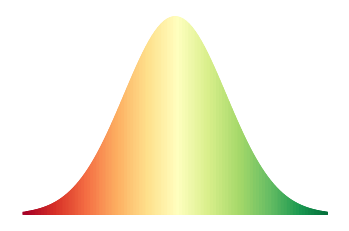

In [356]:
fig, ax = plt.subplots()
ax.axis("off")

mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for i in np.arange(100):
    cmap = matplotlib.cm.get_cmap('RdYlGn')
    rgba = cmap(i/100)
    plt.fill_between(x[i:(i+3)], 0, stats.norm.pdf(x[i:(i+3)], mu, sigma), color=rgba)
plt.xticks([])
plt.yticks([])
plt.show()

In [358]:
# q, typ_response, aff_response
qs = [('q01_phrases', '1', '0'), 
      ('q02_conversation', '1', '0'),
      ('q03_odd_phrase', '0', '1'), 
      ('q04_inappropriate_question', '0', '1'), 
      ('q05_pronouns_mixed', '0', '1'), 
      ('q06_invented_words', '0', '1'), 
      ('q07_same_over', '0', '1'), 
      ('q08_particular_way', '0', '1'), 
      ('q09_expressions_appropriate', '1', '0'), 
      ('q10_hand_tool', '0', '1'), 
      ('q11_interest_preoccupy', '0', '1'), 
      ('q12_parts_object', '0', '1'), 
      ('q13_interests_intensity', '0', '1'), 
      ('q14_senses', '0', '1'), 
      ('q15_odd_ways', '0', '1'),
      ('q16_complicated_movements', '0', '1'), 
      ('q17_injured_deliberately', '0', '1'), 
      ('q18_objects_carry', '0', '1'), 
      ('q19_best_friend', '1', '0'), 
      ('q20_talk_friendly', '1', '0'), 
      ('q21_copy_you', '1', '0'),
      ('q22_point_things', '1', '0'), 
      ('q23_gestures_wanted', '1', '0'), 
      ('q24_nod_head', '1', '0'), 
      ('q25_shake_head', '1', '0'), 
      ('q26_look_directly', '1', '0'), 
      ('q27_smile_back', '1', '0'), 
      ('q28_things_interested', '1', '0'), 
      ('q29_share', '1', '0'), 
      ('q30_join_enjoyment', '1', '0'), 
      ('q31_comfort', '1', '0'),
      ('q32_help_attention', '1', '0'), 
      ('q33_range_expressions', '1', '0'), 
      ('q34_copy_actions', '1', '0'), 
      ('q35_make_believe', '1', '0'), 
      ('q36_same_age', '1', '0'), 
      ('q37_respond_positively', '1', '0'), 
      ('q38_pay_attention', '1', '0'), 
      ('q39_imaginative_games', '1', '0'), 
      ('q40_cooperatively_games', '1', '0')]

# pull individuals from phenotype file
phen_children = []
with open('../../PhasingFamilies/phenotypes/spark/scq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    phen_children = [pieces[0] for pieces in reader]
print('children', len(phen_children))
phen_child_to_index = dict([(x, i) for i, x in enumerate(phen_children)])


phenotype = []
with open('../../PhasingFamilies/phenotypes/spark/scq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for pieces in reader:
        phenotype.append([])
        for q, typ_response, aff_response in qs:
            q_index = header.index(q)
            phenotype[-1].append(1 if pieces[q_index]==aff_response else 0 if pieces[q_index]==typ_response else -1)
phenotype = np.array(phenotype)
print(phenotype.shape)

children 43184
(43184, 40)


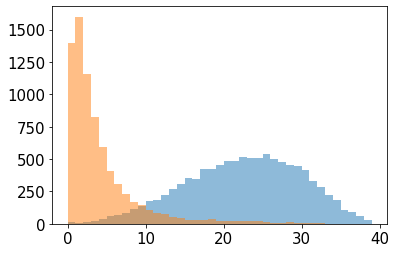

In [359]:
aff_phen, typ_phen = [], []
for i, phen_child in enumerate(phen_children):
    if phen_child in sample_to_affected:
        if sample_to_affected[phen_child] == '2':
            aff_phen.append(np.sum(phenotype[i, :]==1))
        elif sample_to_affected[phen_child] == '1':
            typ_phen.append(np.sum(phenotype[i, :]==1))
            
plt.hist(aff_phen, np.arange(40), alpha=0.5)
plt.hist(typ_phen, np.arange(40), alpha=0.5)
plt.show()

In [360]:
aff_sex, typ_sex = [], []
for i, phen_child in enumerate(phen_children):
    if phen_child in sample_to_affected:
        if sample_to_affected[phen_child] == '2':
            aff_sex.append(sample_to_sex[phen_child])
        elif sample_to_affected[phen_child] == '1':
            typ_sex.append(sample_to_sex[phen_child])
            
print(Counter(aff_sex))
print(Counter(typ_sex))

Counter({'1': 8275, '2': 2078})
Counter({'1': 3793, '2': 3724})


In [361]:
dads = set([x.dad for x in sibpairs if x in phen_child_to_index])
print(len(dads))
print(Counter([phenotype[phen_child_to_index[x], 7] for x in dads]))

0
Counter()


In [362]:
for i in range(40):
    #is_aff_aff = np.array([sp.num_affected==2 for sp in sibpairs])
    #is_aff_typ = np.array([sp.num_affected==1 for sp in sibpairs])
    #is_typ_typ = np.array([sp.num_affected==0 for sp in sibpairs])
    
    phen1 = np.array([-1 if sp.sibling1 not in phen_child_to_index else phenotype[phen_child_to_index[sp.sibling1], i] for sp in sibpairs])
    phen2 = np.array([-1 if sp.sibling2 not in phen_child_to_index else phenotype[phen_child_to_index[sp.sibling2], i] for sp in sibpairs])
    
    is_aff_aff = (phen1==1) & (phen2==1)
    is_aff_typ = (((phen1==1) & (phen2==0)) | ((phen1==0) & (phen2==1)))
    is_typ_typ = (phen1==0) & (phen2==0)

    x = np.sum(ctbp2_is_mat_match[is_typ_typ]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ]==1)
    n = np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1)
    p = stats.binom_test(x, n, p=0.5, alternative='greater')
                         
    x_mat = np.sum(ctbp2_is_mat_match[is_typ_typ]==1)
    n_mat = np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1)
    p_mat = stats.binom_test(x_mat, n_mat, p=0.5, alternative='greater')
    
    x_pat = np.sum(ctbp2_is_pat_match[is_typ_typ]==1)
    n_pat = np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1)
    p_pat = stats.binom_test(x_pat, n_pat, p=0.5, alternative='greater')
    
    x_aut = np.sum(ctbp2_is_mat_match[is_aff_aff]==1) + np.sum(ctbp2_is_pat_match[is_aff_aff]==1)
    n_aut = np.sum(ctbp2_is_mat_match[is_aff_aff]!=-1) + np.sum(ctbp2_is_pat_match[is_aff_aff]!=-1)
    p_aut = stats.binom_test(x_aut, n_aut, p=0.5, alternative='greater')
                         
    x_mat_aut = np.sum(ctbp2_is_mat_match[is_aff_aff]==1)
    n_mat_aut = np.sum(ctbp2_is_mat_match[is_aff_aff]!=-1)
    p_mat_aut = stats.binom_test(x_mat_aut, n_mat_aut, p=0.5, alternative='greater')
    
    x_pat_aut = np.sum(ctbp2_is_pat_match[is_aff_aff]==1)
    n_pat_aut = np.sum(ctbp2_is_pat_match[is_aff_aff]!=-1)
    p_pat_aut = stats.binom_test(x_pat_aut, n_pat_aut, p=0.5, alternative='greater')
    
    if p<0.05/40 or p_mat<0.05/40 or p_pat<0.05/40:
        print()
        print(qs[i][0])
        print(p, x, n-x)
        print(p_mat, x_mat, n_mat-x_mat)
        print(p_pat, x_pat, n_pat-x_pat)
        
        


q08_particular_way
0.015736392883259582 680 602
0.6838251706085956 309 320
0.00028184453453606266 371 282


0 0.4912559618441971 [0.03965596 0.03984404] 1.306734696436809e-38
1 0.5681470137825421 [0.03894701 0.03845299] 9.40004444363301e-67
0 0.5305084745762711 [0.04110847 0.04089153] 6.061563872757149e-48
1 0.49022801302931596 [0.04012801 0.04037199] 1.6076375765340945e-37


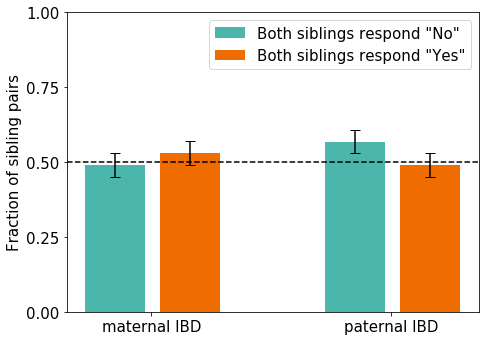

In [364]:
phen1 = np.array([-1 if sp.sibling1 not in phen_child_to_index else phenotype[phen_child_to_index[sp.sibling1], 7] for sp in sibpairs])
phen2 = np.array([-1 if sp.sibling2 not in phen_child_to_index else phenotype[phen_child_to_index[sp.sibling2], 7] for sp in sibpairs])
    
is_aff_aff = (phen1==1) & (phen2==1)
is_aff_typ = (((phen1==1) & (phen2==0)) | ((phen1==0) & (phen2==1)))
is_typ_typ = (phen1==0) & (phen2==0)


typ_typ_counts = np.array([np.sum((ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==1) & is_typ_typ)])

aff_aff_counts = np.array([np.sum((ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==1) & is_aff_aff)])

plt.figure(figsize=(7, 5))
width = 0.25

plot_with_error(typ_typ_counts, np.array([np.sum((ctbp2_is_mat_match!=-1) & is_typ_typ),
                                 np.sum((ctbp2_is_pat_match!=-1) & is_typ_typ)]), 
                np.arange(2), colors[3], 'Both siblings respond "No"', p=0.5)
plot_with_error(aff_aff_counts, np.array([np.sum((ctbp2_is_mat_match!=-1) & is_aff_aff),
                                 np.sum((ctbp2_is_pat_match!=-1) & is_aff_aff)]), 
                np.arange(2)+1.25*width, colors[2], 'Both siblings respond "Yes"', p=0.5)

plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(2)+0.6*width, ['maternal IBD', 'paternal IBD'])
plt.legend()
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')

plt.tight_layout()
plt.show()

In [ ]:
# q, typ_response, aff_response
q_groups = [('communication', [('q02_conversation', '1', '0'),
                               ('q03_odd_phrase', '0', '1'), 
                               ('q04_inappropriate_question', '0', '1'), 
                               ('q05_pronouns_mixed', '0', '1'), 
                               ('q06_invented_words', '0', '1'),
                               ('q20_talk_friendly', '1', '0'), 
                               ('q21_copy_you', '1', '0'),
                               ('q22_point_things', '1', '0'), 
                               ('q23_gestures_wanted', '1', '0'), 
                               ('q24_nod_head', '1', '0'), 
                               ('q25_shake_head', '1', '0'), 
                               ('q34_copy_actions', '1', '0'), 
                               ('q35_make_believe', '1', '0')]),
            ('social', [('q09_expressions_appropriate', '1', '0'),
                        ('q10_hand_tool', '0', '1'), 
                        ('q19_best_friend', '1', '0'), 
                        ('q26_look_directly', '1', '0'), 
                        ('q27_smile_back', '1', '0'), 
                        ('q28_things_interested', '1', '0'), 
                        ('q29_share', '1', '0'), 
                        ('q30_join_enjoyment', '1', '0'), 
                        ('q31_comfort', '1', '0'),
                        ('q32_help_attention', '1', '0'), 
                        ('q33_range_expressions', '1', '0'), 
                        ('q36_same_age', '1', '0'), 
                        ('q37_respond_positively', '1', '0'),
                        ('q39_imaginative_games', '1', '0'), 
                        ('q40_cooperatively_games', '1', '0')]),
            ('repetitive', [('q07_same_over', '0', '1'), 
                            ('q08_particular_way', '0', '1'),
                            ('q11_interest_preoccupy', '0', '1'), 
                            ('q12_parts_object', '0', '1'), 
                            ('q13_interests_intensity', '0', '1'), 
                            ('q14_senses', '0', '1'), 
                            ('q15_odd_ways', '0', '1'),
                            ('q16_complicated_movements', '0', '1')])
           ]

for g, qs in q_groups:
    print()
    child_to_phenotype = dict()
    child_to_asd = dict()
    with open('../phenotypes/spark/scq.csv', 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        q_indices = [header.index(q[0]) for q in qs]
        asd_index = header.index('asd')
        for pieces in reader:
            responses = [pieces[q_index] for q_index in q_indices]
            if np.all([r==typ or r==aff for r, (_, typ, aff) in zip(responses, qs)]):
                child_to_phenotype[pieces[0]] = np.sum([r==aff for r, (_, _, aff) in zip(responses, qs)]) 
                child_to_asd[pieces[0]] = pieces[asd_index]

    plt.hist([child_to_phenotype[x] for x in child_to_phenotype.keys() if child_to_asd[x]=='TRUE'], alpha=0.5)
    plt.hist([child_to_phenotype[x] for x in child_to_phenotype.keys() if child_to_asd[x]=='FALSE'], alpha=0.5)
    plt.title(g)
    plt.show()

    cutoff = 0
    is_aff_aff = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]>cutoff and child_to_phenotype[sp.sibling2]>cutoff for sp in sibpairs])
    is_aff_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and ((child_to_phenotype[sp.sibling1]>cutoff and child_to_phenotype[sp.sibling2]<=cutoff) or (child_to_phenotype[sp.sibling1]<=cutoff and child_to_phenotype[sp.sibling2]>cutoff)) for sp in sibpairs])
    is_typ_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]<=cutoff and child_to_phenotype[sp.sibling2]<=cutoff for sp in sibpairs])

    print(np.sum(is_aff_aff), np.sum(is_aff_typ), np.sum(is_typ_typ))
    
    print(np.sum(is_mat_match[is_typ_typ]==1), np.sum(is_pat_match[is_typ_typ]==1))
    print(np.sum(is_mat_match[is_typ_typ]==0), np.sum(is_pat_match[is_typ_typ]==0))
    p = stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    p_mat = stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    p_pat = stats.binom_test(np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    
    print(g)
    print(p, p_mat, p_pat)

    #print(stats.binom_test(np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))
    #print(stats.chi2_contingency([[np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))


In [ ]:
print(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1))
print(np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1))
print(stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))


In [ ]:
family_to_num_affected = defaultdict(set)
with open(orig_ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[5]=='2':
            family_to_num_affected[pieces[0]].add(pieces[1])
            
is_multiplex = np.array([len(family_to_num_affected[x.family.split('.')[0]])>=2 for x in sibpairs])
print(np.sum(is_multiplex), np.sum(~is_multiplex))

In [ ]:
print(len([sibpairs[i] for i in np.where((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex)[0]]))

print(np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & ~is_multiplex))


In [ ]:
print(np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex))


In [ ]:
print(np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex))



In [ ]:
print(np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & ~is_multiplex))

In [ ]:
c = [
    [
        2*np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex),
        2*np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex)
    ],
    [
        2*np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex),
        2*np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex)
    ]]
print(c)
print(stats.chi2_contingency(c))

In [ ]:
num_het_aff = []
num_het_unaff = []
for sibpair in sibpairs:
    if sibpair.num_affected == 1:
        if sample_to_affected[sibpair.sibling1]=='2' and sample_to_affected[sibpair.sibling2]=='1':
            num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1))
            num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1))
        elif sample_to_affected[sibpair.sibling1]=='1' and sample_to_affected[sibpair.sibling2]=='2':
            num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1))
            num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1))
        else:
            print('Problem')
            

In [ ]:
num_het_aff = np.array(num_het_aff)
num_het_unaff = np.array(num_het_unaff)


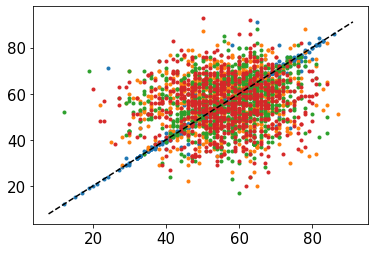

In [28]:
mm = np.array([x for x, sibpair in zip(ctbp2_is_mat_match, sibpairs) if sibpair.num_affected==1]).astype(bool)
pm = np.array([x for x, sibpair in zip(ctbp2_is_pat_match, sibpairs) if sibpair.num_affected==1]).astype(bool)
plt.scatter(num_het_aff[mm & pm], num_het_unaff[mm & pm], marker='.')
plt.scatter(num_het_aff[mm & ~pm], num_het_unaff[mm & ~pm], marker='.')
plt.scatter(num_het_aff[~mm & pm], num_het_unaff[~mm & pm], marker='.')
plt.scatter(num_het_aff[~mm & ~pm], num_het_unaff[~mm & ~pm], marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

In [29]:
print(stats.ttest_rel(num_het_aff, num_het_unaff))

Ttest_relResult(statistic=0.6837116430350999, pvalue=0.4942083867350928)


In [91]:
print(np.sum(np.array(num_het_aff)>np.array(num_het_unaff)))
print(np.sum(np.array(num_het_aff)<np.array(num_het_unaff)))
print(np.sum(np.array(num_het_aff)==np.array(num_het_unaff)))

print(stats.binom_test(np.sum(num_het_aff[mm & pm]>num_het_unaff[mm & pm]), np.sum(num_het_aff[mm & pm]!=num_het_unaff[mm & pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[mm & ~pm]>num_het_unaff[mm & ~pm]), np.sum(num_het_aff[mm & ~pm]!=num_het_unaff[mm & ~pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~mm & pm]>num_het_unaff[~mm & pm]), np.sum(num_het_aff[~mm & pm]!=num_het_unaff[~mm & pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~mm & ~pm]>num_het_unaff[~mm & ~pm]), np.sum(num_het_aff[~mm & ~pm]!=num_het_unaff[~mm & ~pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff[mm]>num_het_unaff[mm]), np.sum(num_het_aff[mm]!=num_het_unaff[mm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[pm]>num_het_unaff[pm]), np.sum(num_het_aff[pm]!=num_het_unaff[pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff[~mm]>num_het_unaff[~mm]), np.sum(num_het_aff[~mm]!=num_het_unaff[~mm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~pm]>num_het_unaff[~pm]), np.sum(num_het_aff[~pm]!=num_het_unaff[~pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff>num_het_unaff), np.sum(num_het_aff!=num_het_unaff), alternative='greater'))



1286
1223
591
0.34455199303050726
0.9373412694094969
0.014568168099188818
0.09603520693714412

0.8521710588176694
0.01875643305104364

0.006318282695213842
0.5621530738469471

0.1078958805619051


In [57]:
print(stats.ttest_rel(num_het_aff, num_het_unaff))

Ttest_relResult(statistic=0.6837116430350999, pvalue=0.4942083867350928)


In [61]:
num_het_aff = []
num_het_unaff = []
for sibpair in sibpairs:
    par_avg = 0.5*(np.sum(gen[sample_to_index[sibpair.mom], indices].A==1) + np.sum(gen[sample_to_index[sibpair.dad], indices].A==1))
    if sample_to_affected[sibpair.sibling1]=='2':
        num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1) - par_avg)
    elif sample_to_affected[sibpair.sibling1]=='1':
        num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1) - par_avg)
        
    if sample_to_affected[sibpair.sibling2]=='2':
        num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1) - par_avg)
    elif sample_to_affected[sibpair.sibling2]=='1':
        num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1) - par_avg)


In [62]:
print(stats.ttest_ind(num_het_aff, num_het_unaff))

Ttest_indResult(statistic=1.2001225757942358, pvalue=0.23012852722439786)


In [319]:
gen_data = gen[:, indices].A
gen_data[gen_data<0] = 0
num_alleles_aut = np.sum(gen_data[has_autism, :], axis=0)
num_alleles_typ = np.sum(gen_data[no_autism, :], axis=0)


In [320]:
af_bins = np.array([10**-x for x in np.arange(0, 5, 0.1)])
af_bin_aut_counts = np.zeros((af_bins.shape[0]+1,), dtype=int)
af_bin_typ_counts = np.zeros((af_bins.shape[0]+1,), dtype=int)
print(af_bins)

[1.00000000e+00 7.94328235e-01 6.30957344e-01 5.01187234e-01
 3.98107171e-01 3.16227766e-01 2.51188643e-01 1.99526231e-01
 1.58489319e-01 1.25892541e-01 1.00000000e-01 7.94328235e-02
 6.30957344e-02 5.01187234e-02 3.98107171e-02 3.16227766e-02
 2.51188643e-02 1.99526231e-02 1.58489319e-02 1.25892541e-02
 1.00000000e-02 7.94328235e-03 6.30957344e-03 5.01187234e-03
 3.98107171e-03 3.16227766e-03 2.51188643e-03 1.99526231e-03
 1.58489319e-03 1.25892541e-03 1.00000000e-03 7.94328235e-04
 6.30957344e-04 5.01187234e-04 3.98107171e-04 3.16227766e-04
 2.51188643e-04 1.99526231e-04 1.58489319e-04 1.25892541e-04
 1.00000000e-04 7.94328235e-05 6.30957344e-05 5.01187234e-05
 3.98107171e-05 3.16227766e-05 2.51188643e-05 1.99526231e-05
 1.58489319e-05 1.25892541e-05]


In [321]:
af_bin_aut_counts[np.digitize(af[indices], af_bins)] += num_alleles_aut
af_bin_typ_counts[np.digitize(af[indices], af_bins)] += num_alleles_typ

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


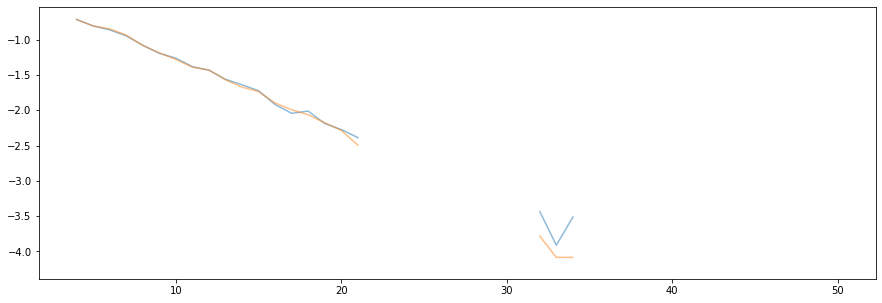

In [329]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(af_bin_aut_counts/np.sum(af_bin_aut_counts)), alpha=0.5)
plt.plot(np.log10(af_bin_typ_counts/np.sum(af_bin_typ_counts)), alpha=0.5)
plt.show()

In [332]:
print(np.sum(af_bin_aut_counts[20:]))
print(np.sum(af_bin_typ_counts[20:]))

199
128


In [334]:
rare_indices = (coords[:, 1]>=start_interval) & (coords[:, 1]<=end_interval) & (coords[:, 2]==1) & (coords[:, 3]==1) & (af<=0.01)
print(np.sum(rare_indices))

22


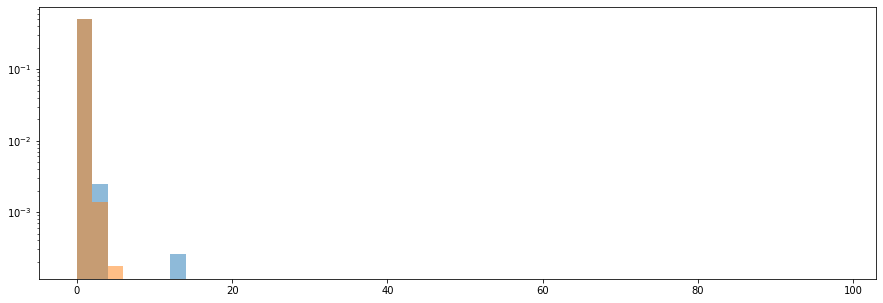

In [348]:
rare_gen_data = gen[:, rare_indices].A
rare_gen_data[rare_gen_data<0] = 0

plt.figure(figsize=(15, 5))

plt.hist(np.sum(rare_gen_data[has_autism, :], axis=1), alpha=0.5, bins=np.arange(0, 100, 2), density=True, log=True)
plt.hist(np.sum(rare_gen_data[no_autism, :], axis=1), alpha=0.5, bins=np.arange(0, 100, 2), density=True, log=True)
plt.show()

In [350]:
print(stats.ttest_ind(np.sum(gen_data[has_autism, :], axis=1), np.sum(gen_data[no_autism, :], axis=1)))
print(stats.ttest_ind(np.sum(rare_gen_data[has_autism, :], axis=1), np.sum(rare_gen_data[no_autism, :], axis=1)))

Ttest_indResult(statistic=1.113230268760339, pvalue=0.26564906997354887)
Ttest_indResult(statistic=1.2027245065123269, pvalue=0.22912500829869908)
